In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import matplotlib
from classes import ModelWrapper, DataLoader, Cluster, Vector, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-04-05 16:01:41.007617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-05 16:11:03.717512: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


21/21 [==============================] - 5s 189ms/step


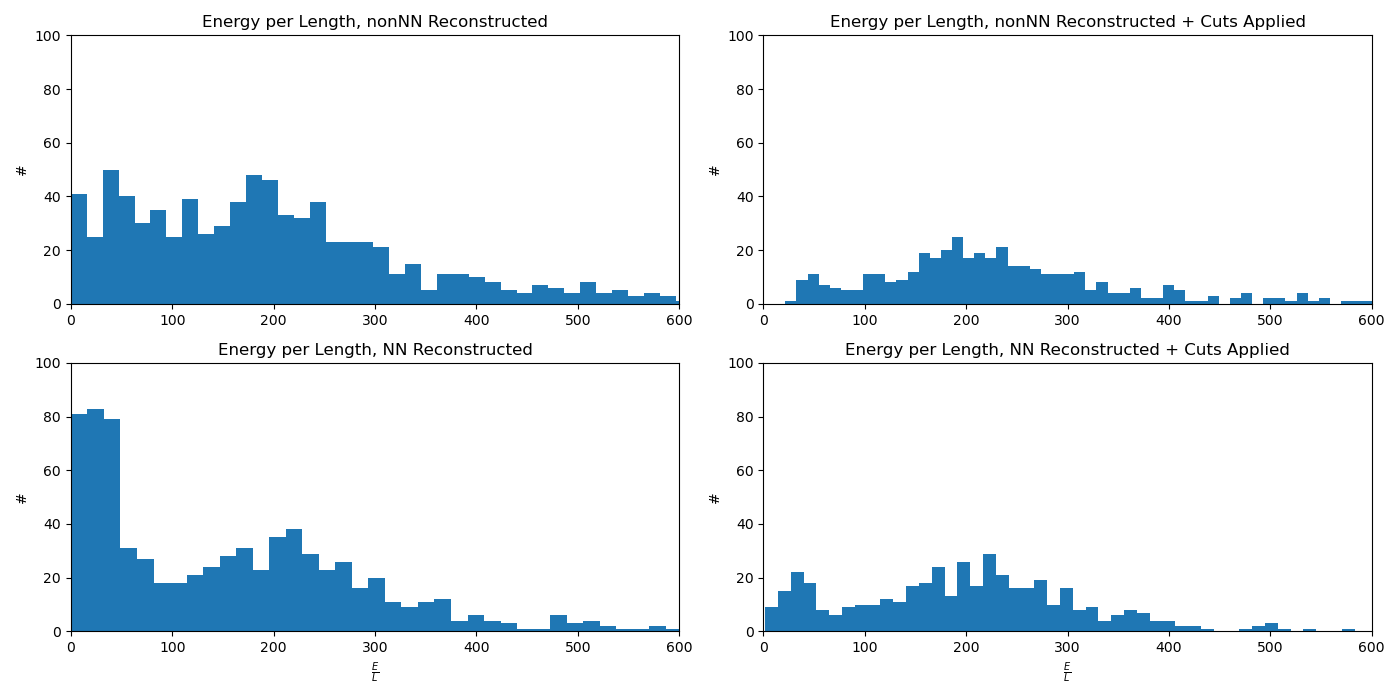

In [52]:
#Four reconstruction energy histograms
def getEnergies(data :numpy.ndarray, clusterConditionFunc):
	energy_density = []
	energy = []

	for i in range(data.shape[0]):
		for cluster in Cluster.clusterise(data[i]):
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if clusterConditionFunc(cluster):
				energy_density.append(cluster.energy / cluster.length)
				for coord in cluster.coords:
					energy.append(noisy_with_E[i][coord])
	
	return (energy_density, energy)


modelAPI = ModelWrapper.loadPostprocessed("../models/3D/small", "paralel")
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
good_NN = Cluster.getGoodFromDataset(classified, noisy_with_E)
names = data_loader.getX17Names(track_type)

# (i,j) ... i==1 NN, j==1 cuts
cluster_densities = [[None, None],[None, None]]
cluster_densities[0][0], _ = getEnergies(clean, lambda x: True)
cluster_densities[1][0], _ = getEnergies(classified, lambda x: True)
cluster_densities[0][1], _ = getEnergies(clean, lambda x: all(x.tests[key] for key in ["length", "neighbours", "zone"]))
cluster_densities[1][1], _ = getEnergies(classified, lambda x: all(x.tests[key] for key in ["length", "neighbours", "zone"]))

fig, ax = matplotlib.pyplot.subplots(2,2)
for i in [0,1]:
	for j in [0,1]:
		ax[i][j].hist(cluster_densities[i][j], 60)
		if i == 1:	ax[i][j].set_xlabel(r"$\frac{E}{L}$")
		ax[i][j].set_ylabel("#")
		ax[i][j].set_ylim(0,100)
		ax[i][j].set_xlim(0,600)

ax[0][0].set_title("Energy per Length, nonNN Reconstructed")
ax[1][0].set_title("Energy per Length, NN Reconstructed")
ax[0][1].set_title("Energy per Length, nonNN Reconstructed + Cuts Applied")
ax[1][1].set_title("Energy per Length, NN Reconstructed + Cuts Applied")

fig.set_size_inches(14, 7)
fig.tight_layout()
matplotlib.pyplot.show()

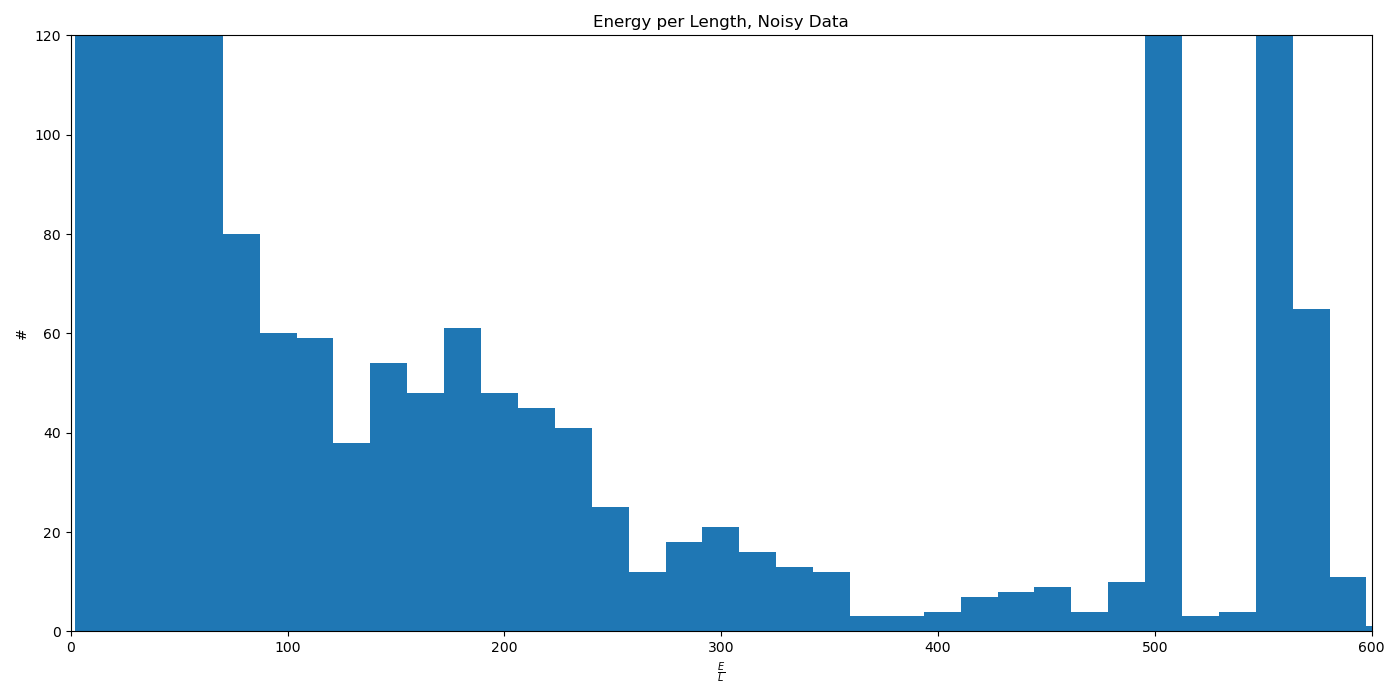

In [8]:
#Noisy
cluster_densities, _ = getEnergies(noisy, lambda x: True)
fig, ax = matplotlib.pyplot.subplots(1)
bin_heights, bin_borders, _ = ax.hist(cluster_densities, 60, log=False, density=False)
ax.set_title("Energy per Length, Noisy Data")
ax.set_xlabel(r"$\frac{E}{L}$")
ax.set_ylabel("#")
ax.set_ylim(0,120)
ax.set_xlim(0,600)

fig.set_size_inches(14, 7)
fig.tight_layout()
matplotlib.pyplot.show()

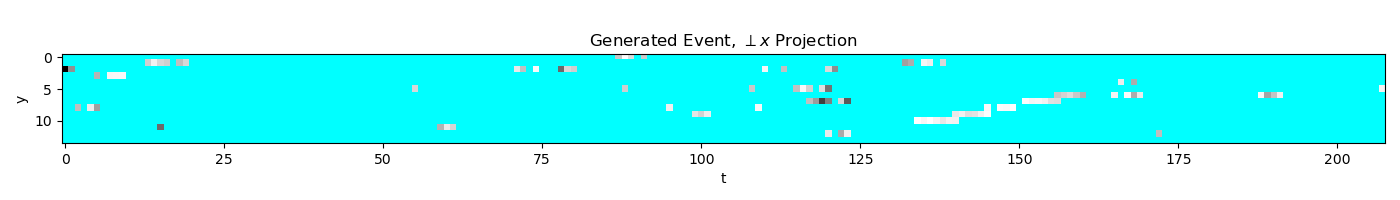

In [51]:
#View generated data
data_loader = DataLoader("../data")
cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')
eps = 1e-8

events = data_loader.getBatch(False, True, 0, normalising=False)
event = events[59]
fig, ax = matplotlib.pyplot.subplots()
ax.imshow(numpy.sum(event,0), cmap, vmin=eps)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Generated Event, $\perp x$ Projection")
fig.set_size_inches(14, 2)
fig.tight_layout()
matplotlib.pyplot.show()